In [60]:
# cell used to import important library of the notebook
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from utils import * # contains all helper functions used in the project
import scipy as sci
from sklearn.cluster import KMeans
import sklearn.metrics as sm

# I. Load, clean, study and prepare the data for graph creation
## I.1 Data cleaning & preperation
**Preparing IRS data**

In [13]:
#load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )
# create the combined fips county number of destination
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-destination'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# create the combined fips county number of source
df_migrations['statefips_str1'] = df_migrations['y1_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str1'] = df_migrations['y1_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-source'] = df_migrations['statefips_str1'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str1']


# Cleaning the data to have only source and origin counties and unemployment rate as a new column
df_migrations = df_migrations[df_migrations['y1_statefips']<=56]
df_migrations["Unemployment rate"] = df_migrations["n1"]/(df_migrations["n2"] +df_migrations["n1"] )

# drop useless information 
df_migrations = df_migrations.drop(columns=["y1_countyname","y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str","statefips_str1", "countyfips_str1"])

# remove nodes where data is undefined undefined data by zero
df_migrations = df_migrations[df_migrations['n1'] != -1]

# convert combined fips to int64
df_migrations['combined_fips-destination'] = df_migrations['combined_fips-destination'].astype('int64')
df_migrations['combined_fips-source'] = df_migrations['combined_fips-source'].astype('int64')

#extracting the combined fips destination and combined fips source for graph in form of numpy arrays
df_graph= df_migrations.drop(columns=["n1","n2","agi","Unemployment rate"])

# extracting all the combinations that have happened in the US between county
dest_source = df_graph.to_numpy()

# reset index starting from 0 (because rows were dropped)
df_migrations = df_migrations.reset_index()
df_migrations = df_migrations.drop(columns=['index'])

**From the IRS dataset create adjency matrix**  
In this adjency matrix, the nodes are the counties and the edges are :
- `A_total[i, j]` := total number of people who migrated from county i to county j
- `A_returns[i, j]` := number of people who migrated from i to j and payed taxes 
- `A_exempt[i, j]` := number of people who migrated from county i to county j and did not payed taxes


In [14]:
nodes_index = np.unique(dest_source)
num_nodes = nodes_index.shape[0]
A_total = np.zeros((num_nodes, num_nodes))
A_returns = np.zeros((num_nodes, num_nodes))
A_exemptions = np.zeros((num_nodes, num_nodes))
count = 0
for dest, source in dest_source : 
    i = np.where(nodes_index == dest)
    j = np.where(nodes_index == source)
    total = df_migrations["n1"][count] + df_migrations["n2"][count]
    
    A_total[j[0], i[0]] = df_migrations["n1"][count] + df_migrations["n2"][count]
    A_returns[j[0], i[0]] = df_migrations["n1"][count]/total
    A_exemptions[j[0], i[0]] = df_migrations["n2"][count]/total
    count += 1

**Preparing the presidential result by county dataset**   
The main idea in this cell is to prepare the presidential result by county dataset. To each county a label is given : $+1$ if the county has a majority of Republican and $-1$ if the county has a majority of Democrat

In [15]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

#Sorting according to the fips code to be consistent with the migration data by IRS
df_presidential_result = df_presidential_result.sort_values(by=['combined_fips'])

#Adding a new column of the winners with -1 corresponding to democrat and 1 to republican

df_presidential_result["Winner"] =  np.where((df_presidential_result['per_dem'] > df_presidential_result['per_gop']), -1, 1)

df_presidential_result = df_presidential_result.drop(columns=["per_dem","per_gop"])

# Redindex some FIPS due to difference between FIPS
test = nodes_index - df_presidential_result["combined_fips"].values
df_presidential_result["combined_fips"] = df_presidential_result["combined_fips"] + test

## I.2 Study the datasets at hand 
First we study the proportion of people paying taxes and not paying taxes for each migration flow. An histogram of these migration is plotted.  
As one can see, on average, $35$% of the people in a migration flow are paying taxes (and conversly $65$% are exempt from paying taxes).   
At most, $50$% of the people in a migration flow will pay taxes. Hence, it is intersting to note that most people who migrate are not exempt from paying taxes. 
In subsequent part of this notebook, we will try to see if we can use these proportions to predict if a county is either voting Republican or Democrat. 

In [16]:
# <returns, exempt>
node_pct = np.zeros((df_migrations.shape[0], 2))
for i in range (0, df_migrations.shape[0]) : 
    total = df_migrations['n1'][i] + df_migrations['n2'][i]
    node_pct[i, 0] = df_migrations['n1'][i] / total
    node_pct[i, 1] = df_migrations['n2'][i] / total
df_node_pct = pd.DataFrame(node_pct, columns=["pct_return", "pct_exempt"])

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


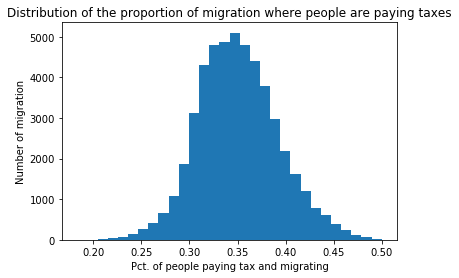

In [17]:
plt.hist(df_node_pct["pct_return"].values, normed=False, bins=30)
plt.title('Distribution of the proportion of migration where people are paying taxes')
plt.ylabel('Number of migration');
plt.xlabel('Pct. of people paying tax and migrating');

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


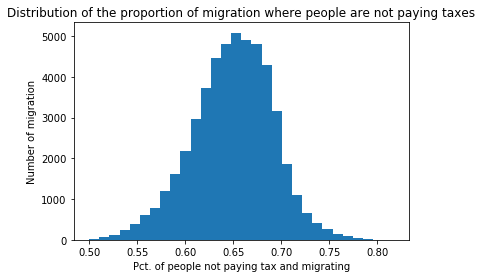

In [18]:
plt.hist(df_node_pct["pct_exempt"].values, normed=False, bins=30)
plt.title('Distribution of the proportion of migration where people are not paying taxes')
plt.ylabel('Number of migration');
plt.xlabel('Pct. of people not paying tax and migrating');

One wants to also consider the proportion of Republican and Democrat counties in the US. Before doing the actual computation, a bit of historic background on the US electoral system is required. 
Historically, most of the states in the US are Republican. Hence, if one draws a simple geographic map of the US, he would color most states in red (the color of the Rebublican). However, if then one scales the size each state with the number of inhabitants in each county, then the proportion of blue and red on the map would be more or less equal, with coastal states (states that are on the Atlantic or Pacific coast) in blue, and the inner states red (Republican). 
Our computations verify this historical proportions : more than $84$% of the counties are Republican. 

In [40]:
num_republicans = df_presidential_result[df_presidential_result['Winner'] == 1].shape[0]
num_democrats = df_presidential_result[df_presidential_result['Winner'] == -1].shape[0]
pct_republican = df_presidential_result[df_presidential_result['Winner'] == 1].shape[0] / df_presidential_result.shape[0]
pct_democrat = df_presidential_result[df_presidential_result['Winner'] == -1].shape[0] / df_presidential_result.shape[0]
print("Pct. of counties Republican : ", pct_republican, " // Pct. of counties Democrat : ", pct_democrat)

Pct. of counties Republican :  0.8449538363578478  // Pct. of counties Democrat :  0.15504616364215218


# II. Creation of simple graph following structure of migration & first attempt to predict county type
## II.1 Creation of simple graph
The first graphs that will be studied in this notebook are simple to understand as they follow the structure of a migration : if there is a migration between county i and j, then an edge is set between these to counties. 
Before moving on, it is intersting to note that in this section, we are creating graph that are suppose to show a correlation between a type of migration and a voting pattern in a county. 
When we refer to "type of migration", we mean what kind of proportion is there between people paying taxes and not paying taxes in a specific migration flow. For exemple, we say that a migration flow has a high proportion of people paying taxes if more then $40$% of the people in the migration flow are paying taxes. The idea is to correlate this migration to a specific voting pattern in the destination county. 
To achieve this task we will be creating 2 types of graph : 
- `graph_nonRGB_returns` : in these graph there is a migration between two counties if (1) there is an actual migration between county i and j and (2) if the migration flow as a proportion of people paying taxes greater then a **specified threshold**. 
- `graph_nonRGB_exempt`: same type of graph as before, but now we are studying the proportions of exempted people in a migration flow

In subsequent cells, we code mainly two methods : one for creating `graph_nonRGB_return` graphs and one for creating `graph_nonRGB_exempt` 

**Note :** we refer to graph created in this section as "nonRGB" as in later section we will be using RGB graphs. One can read this notation as being a raw graph built on migration without any kind of similarity extrapolation. 

In [20]:
def create_adjency_nonRGB_returns(threshold_returns, plot_adj_returns=False) : 
    """
    Create the adjency matrix for a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people paying taxes greater than threshold_returns
    """
    adjacency_nonRGB_returns = A_returns.copy()
    adjacency_nonRGB_returns[adjacency_nonRGB_returns >= threshold_returns] = 1
    adjacency_nonRGB_returns[adjacency_nonRGB_returns < threshold_returns] = 0

    if plot_adj_returns : 
        plt.spy(adjacency_nonRGB_returns)
        plt.show()
        
    return adjacency_nonRGB_returns

def create_graph_nonRGB_returns(threshold_returns, plot_adj_returns=False) :
    """
    Create a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people paying taxes greater than threshold_returns
    The attribute plot_adj_returns can is a boolean used if one wants to plot the adjency matrix of the graph
    """
    i = np.where(nodes_index == dest)
    graph_nonRGB_returns = nx.from_numpy_array(create_adjency_nonRGB_returns(threshold_returns, plot_adj_returns))
    nodes = np.zeros((nodes_index.shape[0], 2))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
   
    node = pd.DataFrame(nodes, columns=["id", "result"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_returns, node_props[key], key)

    nx.write_gexf(graph_nonRGB_returns, 'graph_nonRGB_returns_35.gexf')
    return graph_nonRGB_returns

def create_graph_nonRGB_returns_features(threshold_returns, plot_adj_returns=False): 
    i = np.where(nodes_index == dest)
    graph_nonRGB_returns = nx.from_numpy_array(create_adjency_nonRGB_returns(threshold_returns, plot_adj_returns))
    nodes = np.zeros((nodes_index.shape[0], 4))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
   
    for j in range (0, df_migrations.shape[0]): 
        fips = df_migrations['combined_fips-destination'][j]
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 2] = df_migrations['agi'][j]
        nodes[index, 3] = df_migrations['Unemployment rate'][j]
    
    node = pd.DataFrame(nodes, columns=["id", "result", "agi", "unemployment_rate"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_returns, node_props[key], key)

    nx.write_gexf(graph_nonRGB_returns, 'graph_nonRGB_returns_35.gexf')
    return graph_nonRGB_returns, node

In [21]:
# construct graph for flows with more then 45% returns 
# create adjacency matrix for flows with more then 45% returns 
def create_adjency_nonRGB_exempt(thershold_exempt, plot_adj_exempt = False ) : 
    """
    Create the adjency matrix for a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people not paying taxes greater than thershold_exempt
    """
    adjacency_nonRGB_exempt = A_exemptions.copy()
    adjacency_nonRGB_exempt[adjacency_nonRGB_exempt >= thershold_exempt] = 1
    adjacency_nonRGB_exempt[adjacency_nonRGB_exempt < thershold_exempt] = 0
    
    if plot_adj_exempt : 
        plt.spy(adjacency_nonRGB_exempt)
        plt.show()
        
    return adjacency_nonRGB_exempt

def create_graph_nonRGB_exempt(threshold_exempt, plot_adj_exempt = False) : 
    """
    Create a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people not paying taxes greater than threshold_exempt
    The attribute plot_adj_exempt can is a boolean used if one wants to plot the adjency matrix of the graph
    """
    i = np.where(nodes_index == dest)
    graph_nonRGB_exempt = nx.from_numpy_array(create_adjency_nonRGB_exempt(threshold_exempt, plot_adj_exempt))
    nodes = np.zeros((nodes_index.shape[0], 2))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
        
    node = pd.DataFrame(nodes, columns=["id", "result"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

    nx.write_gexf(graph_nonRGB_exempt, 'graph_nonRGB_exempt.gexf')
    return graph_nonRGB_exempt

def create_graph_nonRGB_exempt_features(threshold_exempt, plot_adj_exempt = False) :  
    i = np.where(nodes_index == dest)
    graph_nonRGB_exempt = nx.from_numpy_array(create_adjency_nonRGB_exempt(threshold_exempt, plot_adj_exempt))
    nodes = np.zeros((nodes_index.shape[0], 4))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
    
    for j in range (0, df_migrations.shape[0]): 
        fips = df_migrations['combined_fips-destination'][j]
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 2] = df_migrations['agi'][j]
        nodes[index, 3] = df_migrations['Unemployment rate'][j]
        
    node = pd.DataFrame(nodes, columns=["id", "result", "agi", "unemployment_rate"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

    nx.write_gexf(graph_nonRGB_exempt, 'graph_nonRGB_exempt.gexf')
    return graph_nonRGB_exempt, node


## II.2 First attempt at predicting election results
With the graph built in the previous section, we want to see if there is some sort of pattern between a particular structure of the graph and the voting pattern in the county. 
### II.2.1 First observations using Gephi
The first hypothesis that could be stated are the following : 
1. **Hypothesis 1** : a migration flow with a more than 35% people paying taxes will have as destination a republican county. One could think that people paying taxes would like to move to Republican county were taxes such as the proprety tax are lower. 
2. **Hypothesis 2** : a migration flow with a more than 70% people not paying taxes will have as destination a democrat county. One could think that people with the lowest income would move to county were charity is more developed (we are not considering helps from the state, which is the same whatever the state).

To validate or reject these two hypotethis, we are building two graph. The first one considers only the migration flows between counties were more then $38$% of the migrants are paying taxes. The second graph considers only the migration flow between counties where more then $70$% of the migrants are paying taxes. 
If hypothesis 1 is correct, then one observing the first graph on $Gephi$, most of the connection will be toward Republican counties. On the other hand, if hypothesis 2 is correct, then most migration will have as destination a Democrat county. 

In [22]:
create_graph_nonRGB_exempt(0.7)
create_graph_nonRGB_returns(0.35)

Result of the observation on $Gephi$ : 
- *observation on exemption graph* : the exemption graph (i.e graph with edges between nodes where migration is caractersied by more then $70$% of migratiants not paying taxes) doesn't have the structre expected. Edges are going from Democrat to Republican, and to Democrat from Republican in an equal fashion. So hypothesis 2 cannot be validate.
- *observation on return graph* : the return graph (i.e graph with edges between nodes where migration  is caractersised by more then $35$% of migrants paying taxes) doesn't have the expected strcuture. Most of the migration is concentrated between democrat nodes. It appears that migration caracterised by a high rate of people paying taxes is concentrated between Democrat counties.

So as a conclusion, both hypothesis 1 and 2 are rejected. However, it appears that from the return graph if one studies the degree of the node, one could be able to tell if its a Democrat or Republican county. 
### II.2.2 Prediction based on degree of county (i.e node of the graph)
The aforementioned observation tells us that by studying the degree of a node, we might be able to predict the label (i.e Republican or Democrat) of that node. We will now verify this asumption. 

The driving force behind our first prediction algorithm is quiet simple : we believe that we can split the nodes into two categories. The first category being nodes with high degree and the second category being nodes with low degree. These two catagory will then mapped to reciprocally Democrat and Republican.  
However, the problem remains on finding the correct threshold to construct our graph (remember that our graph are constrcuted using a threshold on the proportion of migratants payin taxes or not paying taxes) and what should be the degree that defines the limit between the two aformentionned category. This limit is from now on reffered as the "cut".    
This problem of finding the best possible tuple of hyper-parameters is a cross-validation problem. Hence, the subsequent cell implment a cross validation to find the best possible cut and threshold for this problem anc computes the accuracy of predicting graph in such a way. 

In [44]:
def get_degree_attribute (G) :
    degree_attr = [(G.degree(n), G.nodes[n]['result']) for n in G.nodes()]
    return np.array(degree_attr)

def get_degree_party (degree_attr) : 
    democrats = []
    republicans = []
    for tuple_ in degree_attr : 
        if tuple_[1] == -1 : 
            democrats.append(tuple_[0])
        else : 
            republicans.append(tuple_[0])
    return democrats, republicans 

def compute_accuracy(d, r, best_cut) : 
    pct_dem_predicted_correctly = d[d > best_cut].shape[0]/d.shape[0]
    pct_rep_predicted_correctly = r[r > best_cut].shape[0]/r.shape[0] 
    accuracy = (num_democrats*pct_dem_predicted_correctly + num_republicans*(1 - pct_rep_predicted_correctly))/(num_democrats + num_republicans)
    return accuracy
    
def cross_validation_returns (threshold_range_min, threshold_range_max, step=0.01, print_best=False) : 
    thresholds = np.arange(start=threshold_range_min, stop=threshold_range_max, step=step)
    max_global = 0
    best_cut = 0
    best_threshold = 0
    for threshold in thresholds : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(threshold)
        degree_attr = get_degree_attribute(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        
        d_qt025 = np.quantile(d, 0.25)
        d_qt075 = np.quantile(d, 0.75)
        cuts = np.arange(d_qt025, d_qt075, 1)
        max_local = 0
        cut_local = 0
        for cut in cuts : 
            temp = np.abs(d[d > cut].shape[0]/d.shape[0] - r[r > cut].shape[0]/r.shape[0])
            if temp > max_local : 
                max_local = temp
                cut_local = cut
        
        if max_local > max_global : 
            max_global = max_local
            best_threshold = threshold
            best_cut = cut_local
        
    if print_best : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(best_threshold)
        degree_attr = get_degree_attribute(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        print(d[d > best_cut].shape[0]/d.shape[0])
        print(r[r > best_cut].shape[0]/r.shape[0])   
        plt.hist(d, density=True, bins= 100)
        plt.show()
        plt.hist(r, density=True, bins= 100)
        plt.show()
        accuracy = compute_accuracy(d, r, best_cut)
    return best_cut, best_threshold, accuracy

0.5174537987679672
0.08251695553880935


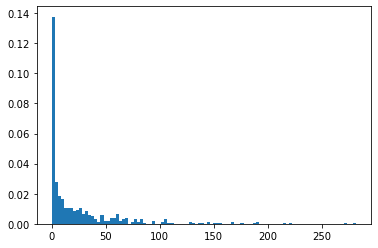

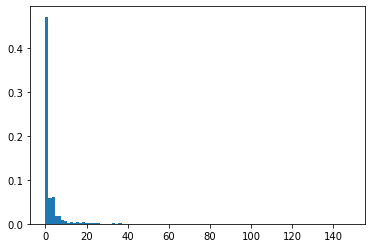

The best cut is :  6.0 and the best threshold is :  0.38000000000000006
W/ overall accuracy :  0.8554600445717925


In [45]:
best_cut_brute, best_threshold_brute, accuracy_brute = cross_validation_returns(0.3, 0.6, print_best=True)
print("The best cut is : ", best_cut_brute, "and the best threshold is : ", best_threshold_brute)
print("W/ overall accuracy : ", accuracy_brute)

The graphs above show that by constructing a graph with migration caractersized by more then $38$% of people paying taxes we can split the nodes of the graph into two categories : the Republican being the nodes with a degree less than 6 and the Democrat being nodes with a degree more than 6. By doing so, we will rightfully caractersied half of the Democrats and $92$% of the Republicans giving an overall accuracy of $85$%. This is not great, as one could simply say that all counties are Republican and get an overall $81$% of accuracy.   

**Note :** we refer as this method as cross-validation, but we are not splitting the data to create a validation set and a proper training set, hence talking about cross-validation here might be an over-statement. However, the term still encapsulate the idea that we are trying to find the best possible tuple (cut, threshold) for this prediction. 
### II.2.3 Prediction based on degree neighboring nodes of county 
The previous technique based on predicting the label of a node based on its absolute degree proved to perform poorly. And the reason was that half of the Democrat nodes are wrongfully predicted. Hence, we try a new technique : predicint the label of a node, based on the average degree of its neighboors.     
The problem with the previous prediction algorithm was that to have a clear cut between two nodes, we had to put a high threshold between counties. A high threshold meant that most of the Republican nodes were having edge-free, but also a high proportion of Democrat nodes were edge-free and hence wrongfully classifed. To solve this problem, we use the fact that we can study the neighboring nodes and reduce the threshold. Hence, eventhough more Republican nodes will have conneciton, we believe that still making the average of all there connection, we will get a lower average degree than for Democrat nodes.   
Also, because this method seemed like a realy good idea, we developped it for the two graphs : returns and exemptions.  

**Study neighboors on the returns graph**

In [57]:
#a_dict = graph_nonRGB_returns.neighbors
def compute_mean (neigh_degree) : 
    if neigh_degree.shape[0] == 0 : 
        return 0
    else :
        return neigh_degree.mean()

def mean_degree_neighbors (G) :
    degree_attr = get_degree_attribute(G)
    mean_degree_neigh = []
    dicts = [G.neighbors(n) for n in G.nodes]
    for a_dict in dicts : 
        neigh_degree = []
        for key in a_dict:
            neigh_degree.append(degree_attr[key][0])        
        mean_degree_neigh.append(compute_mean(np.array(neigh_degree)))
    return np.concatenate((np.array(mean_degree_neigh).reshape(degree_attr.shape[0], 1), degree_attr[:, 1].reshape(degree_attr.shape[0], 1)), axis=1)

def cross_validation_neigh_returns (threshold_range_min, threshold_range_max, step=0.01, print_best=False) : 
    thresholds = np.arange(start=threshold_range_min, stop=threshold_range_max, step=step)
    max_global = 0
    best_cut = 0
    best_threshold = 0
    for threshold in thresholds : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        d_qt025 = np.quantile(d, 0.25)
        d_qt075 = np.quantile(d, 0.75)

        cuts = np.arange(d_qt025, d_qt075, 1)
        max_local = 0
        cut_local = 0
        for cut in cuts : 
            temp = np.abs(d[d > cut].shape[0]/d.shape[0] - np.log(r[r > cut].shape[0]/r.shape[0]))
            if temp > max_local : 
                max_local = temp
                cut_local = cut
        
        if max_local > max_global : 
            max_global = max_local
            best_threshold = threshold
            best_cut = cut_local
        
    if print_best : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(best_threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        print(d[d > best_cut].shape[0]/d.shape[0])
        print(r[r > best_cut].shape[0]/r.shape[0])   
        plt.hist(d, normed=True, bins= 100)
        plt.show()
        plt.hist(r, normed=True, bins= 100)
        plt.show()
        accuracy = compute_accuracy(d, r, best_cut)
    return best_cut, best_threshold, accuracy

0.26078028747433263
0.0146948003014318


/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


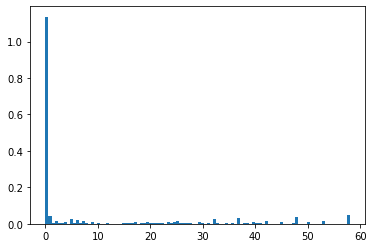

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


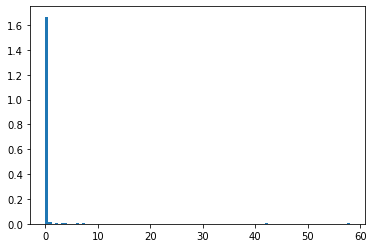

best cut is :  6.0  // best thershold us :  0.46000000000000013
W/ overall accuracy :  0.8729703915950334


In [58]:
best_cut_return, best_thershold_return, accuracy_returns = cross_validation_neigh_returns(0.3, 0.6, print_best=True)
print("best cut is : ", best_cut_return, " // best thershold us : ", best_thershold_return)
print("W/ overall accuracy : ", accuracy_returns)

In [55]:
def cross_validation_neigh_exempt (threshold_range_min, threshold_range_max, step=0.01, print_best=False) : 
    thresholds = np.arange(start=threshold_range_min, stop=threshold_range_max, step=step)
    max_global = 0
    best_cut = 0
    best_threshold = 0
    for threshold in thresholds : 
        graph_nonRGB_exempt = create_graph_nonRGB_exempt(threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_exempt)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        d_qt025 = np.quantile(d, 0.25)
        d_qt075 = np.quantile(d, 0.75)

        cuts = np.arange(d_qt025, d_qt075, 1)
        max_local = 0
        cut_local = 0
        for cut in cuts : 
            temp = np.abs(d[d > cut].shape[0]/d.shape[0] - np.log(r[r > cut].shape[0]/r.shape[0]))
            if temp > max_local : 
                max_local = temp
                cut_local = cut
        
        if max_local > max_global : 
            max_global = max_local
            best_threshold = threshold
            best_cut = cut_local
        
    if print_best : 
        graph_nonRGB_exempt = create_graph_nonRGB_exempt(best_threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_exempt)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        print(d[d > best_cut].shape[0]/d.shape[0])
        print(r[r > best_cut].shape[0]/r.shape[0])   
        plt.hist(d, normed=True, bins= 100)
        plt.show()
        plt.hist(r, normed=True, bins= 100)
        plt.show()
        accuracy = compute_accuracy(d, r, best_cut)
    return best_cut, best_threshold, accuracy

0.25256673511293637
0.05199698568198945


/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


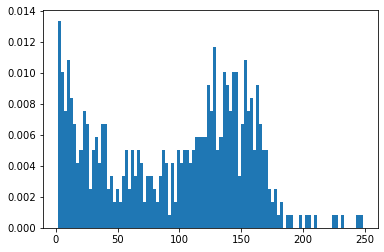

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


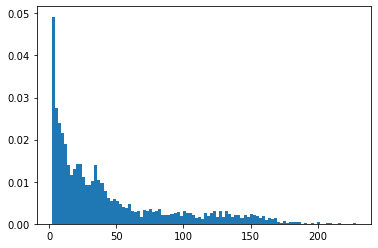

Best cut is :  143.1  // best thershold us :  0.5900000000000001
W/ overall accuracy :  0.8401782871696912


In [59]:
best_cut_exempt, best_thershold_exempt, accuracy_exempt = cross_validation_neigh_exempt(0.55, 0.8, print_best=True)
print("Best cut is : ", best_cut_exempt, " // best thershold us : ", best_thershold_exempt)
print("W/ overall accuracy : ", accuracy_exempt)

When a first try gave us the overall accuracy score of $0.78$% which is clearly a terrible result -- simply put all the counties as Democrat and you would get a better accuracy.    
Hence, a bit of inspiration was taken from Machine Learning. In Machine Learning, when one is faced with heavy tailed targets (i.e most of the dataset at hand is driven toward on specific value) is to use a penalizing function such as the log.  
This is specifically what we introduce here, when we are computing the absolute difference between the number of nodes above the cut, we are penalizing the republican nodes with the log function. By doing so, we are forcing the "loss function" (based on the degree of the nodes) to make sure that the number of nodes above the cut is kept small for Republican (because they are the one who will give us the biggest loss in the end). By doing so, reach an overall accuray of $87$%. 

**Note :** the acutal value of the new loss function is : 
$$ 
loss = |pctOfDemocratAboveCut + log(pctOfRepublicanAboveCut)|
$$

Even with these changements, we were able to improve the result by a mere $2$%, which could be great if not there was such a heavy tail on republican. Hence, we try more sophisticated methods using Lagrange techniques and GCN in subsequent cells in order to reach a higer accuracy.

### II.2.4 Graph observation
**Part of anshul**    
Observe the graph non_RGB_return and non_RGB_exempt and extrapolate information on it. Please link them to the overall them of migration (that degree, distribution are consistant with a migration graph). 


## II.3 Second attempt at predicting election results - GCN and Laplace
As aforementioned, we are now trying more sophisticated methods such as GCN and or using Laplacian. 


### === please correct and complete ===
Explaination of two different methods.
In both two methods, 20% of the target labels are randomly masked to zero. This is served as the test set on which the performance will be evaluated. The remaining target lables are used for training.
Fourier method:
The idea is to use Fourier analysis. Namely we apply the Fourier transform to the signal (our target label) with some missing values. The obtained transform in Fourier domain will be filtered by a lowpass filter which can smooth the signal. When the signal is converted back to the graph domain, some values are assigned to the masked labels. These values can contribute to the prediction. The final prediction of a masked node is obtained by averaging  over the addtion of the value of node itself and values of its neighbours, then thresholding.

To start, we firstly constructed a RGB similary matrix using features associated to each node of the graph. So that all nodes were connected to their neighbours if there existed. Next step, we masked randomly 20% of the whole target to zero. The target was considered as a signal on which Fourier transform was applied afterwards. Since we wanted to reproduce the missing values of masked nodes, we appled a lowpass filter in order to smooth the signal. When the signal was converted back, masked nodes were influenced by its connected neighbours. They did not have null values any more. By summing their values and the values of neighbours and averaging by the number of contributing nodes, we obtained a number for each node. This number is then thresholding into -1 or +1, as the final prediction.


GCN:
to do by Fatima

### === please correct and complete ===


### II.3.1 Fourier and GCN on return graph
First, we are trying Fourier's method and GCN on the return graph (i.e graph where flow have a least more than $38$% of migrants paying taxes).  
The features that are used are the agi (a.k.a average income of the migration flow) and the unemployment rate of the destination county. We are using these two features because we believe that they are important cause of migration. According to recent socio-economic studies, the main push factor for migration are economic reason (at least in the US). The desire for better income or to simply find a job are driving forces of migration. Hence, it appears impossible to study migration and its impact on election result without taking into account the agi and the unemployment rate of the destination county. Hence, the first thing we are doing is creating a graph with label being the $+1, -1$ wether the county is Republican or Democrat and also contains the 2 aforementioned features. 

In [10]:
# creation of the graph // seperation of adjency matrix & label/features for later use 
_, features1 = create_graph_nonRGB_returns_features(0.38)
adjacency_nonRGB_returns = create_adjency_nonRGB_returns(0.38, plot_adj_returns=False)

**Fourier method**   
With this graph we are using the Fourier method to predict the outcome of the election in one particular county

In [43]:
# prepare A_migration and target label
A_migration = adjacency_nonRGB_returns.copy()
# prepare the target label
y_presidential_result = features1["result"].copy()
# compute lamb and U
laplacian_migration = compute_laplacian(A_migration, normalize=True)
lamb_migration, U_migration = spectral_decomposition(laplacian_migration)
# prepare filter
ideal_lp_migration = np.ones((A_migration.shape[0],)) 
ideal_lp_migration[lamb_migration >= 0.1] = 0   # to tune
# apply filter
x_lp_migration = ideal_graph_filter(y_presidential_result.copy(),ideal_lp_migration,U_migration)

3141


In [55]:
iters = 10
n = int(len(y_presidential_result)*0.2)

In [49]:
accuracy_mean_fourier, accuracy_var_fourier = pred_iteration(A_migration,iters, y_presidential_result, n, x_lp_migration)

The mean is  0.8783787613383739
The variance is  0.012052096120726927


Using Fourier transform allows us to predict correctly $87$% of the election result, a similar result to the one found in part II.2.3, where we allready said that the result wasn't terrible. So we move on to GCN method. 


**GCN method**

In [54]:
# determine features to use in GCN
X_migration = features1.drop(columns=['id', 'result']).values
# evaluation GCN performance
accuracy_mean_GCN, accuracy_var_GCN = apply_gcn(iters,X_migration,y_presidential_result,A_migration,laplacian_migration,lamb_migration,U_migration)

Computing
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
The mean of f1 score is  0.9179262282947448
The variance of f1 score is  0.008141397388559221


TO DO : conclusion of GCN

### II.3.2 Fourier and GCN on exemption graph

We are conducting the same study are in part II.3.1 but on the graph of exempltion (i.e graph where the flow are each caraterised by at least $56$% of migrants not paying taxes.

In [57]:
# creation of the graph // seperation of adjency matrix & label/features for later use 
_, features2 = create_graph_nonRGB_exempt_features(0.56)
adjacency_nonRGB_exempt = create_adjency_nonRGB_exempt(0.56, plot_adj_exempt = False )

**Fourier method**

In [60]:
# prepare A_migration and target label
A_migration2 = adjacency_nonRGB_exempt.copy()
# prepare the target label
y_presidential_result2 = features2["result"].copy()
# compute lamb and U
laplacian_migration2 = compute_laplacian(A_migration2, normalize=True)
lamb_migration2, U_migration2 = spectral_decomposition(laplacian_migration2)
# prepare filter
ideal_lp_migration2 = np.ones((A_migration2.shape[0],)) 
ideal_lp_migration2[lamb_migration2 >= 0.1] = 0   # to tune
# apply filter
x_lp_migration2 = ideal_graph_filter(y_presidential_result2.copy(),ideal_lp_migration2,U_migration2)

3141


In [61]:
iters = 10
n = int(len(y_presidential_result2)*0.2)

In [62]:
accuracy_mean_fourier2, accuracy_var_fourier2 = pred_iteration(A_migration2,iters, y_presidential_result2, n, x_lp_migration2)

The mean is  0.9152864778844094
The variance is  0.005928087066779828


With the exemption graph we achieve an accuracy of $92$%, a result that starts to be rather conclusive.    

**GCN method**

In [63]:
# determine features to use in GCN
X_migration2 = features2.drop(columns=['id', 'result']).values
# evaluation GCN performance
accuracy_mean_GCN2, accuracy_var_GCN2 = apply_gcn(iters,X_migration2,y_presidential_result2,A_migration2,laplacian_migration2,lamb_migration2,U_migration2)

Computing
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
The mean of f1 score is  0.9160513632835862
The variance of f1 score is  0.007575300015881553


TO DO : conclucion of GCN

# III. Study of a similarity graph for prediction 
Result of the previous section were good, but still far from being great, hence we are now moving on to construct another type of graph : similarity graph using an RGB kernel.   
Using such a graph will be interesting in the sense that the IRS will allow us to add another dimension to the graph: the origin of the migrant, if they are either US citizen or migrant. This allows us to capture the polorazing aspect of migration : immigration of foreigner. 

To construct the similarity graph we re-prepare the IRS dataset (now we are considering other part of the IRS dataset -- the one that allows us to do the seperation between foreigner and US citizen). 

## III.1. Clean and prepare the data

In [62]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

In [63]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

# keep only summury information of each county
df_migrations = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration")]

# create the combined fips county number 
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# drop useless information 
df_migrations = df_migrations.drop(columns=["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str"])

# seperate each possible migration into three dataframe 
df_migration_total = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
df_migrations['y1_countyname'] = df_migrations['y1_countyname'].apply(lambda x : x if x.find("County Total Migration-US and Foreign") == -1 else "County Total Migration Both")
df_migration_us = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US")]
df_migration_for = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-Foreign")]

# drop the name of the column 
df_migration_total = df_migration_total.drop(columns=["y1_countyname"])
df_migration_us = df_migration_us.drop(columns=["y1_countyname"])
df_migration_for = df_migration_for.drop(columns=["y1_countyname"])

# remove nodes where data is undefined undefined data by zero
df_migration_total = df_migration_total[df_migration_total['n1'] != -1]
df_migration_us = df_migration_us[df_migration_us['n1'] != -1]
df_migration_for = df_migration_for[df_migration_for['n1'] != -1]

# convert combined fips to int64
df_migration_total['combined_fips'] = df_migration_total['combined_fips'].astype('int64')
df_migration_us['combined_fips'] = df_migration_us['combined_fips'].astype('int64')
df_migration_for['combined_fips'] = df_migration_for['combined_fips'].astype('int64')

In [64]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

In [65]:
# merge the two dataset and drop useless column, add a new column winner 
df_merged_total = pd.merge(df_migration_total, df_presidential_result, on="combined_fips", how='inner')
df_merged_us = pd.merge(df_migration_us, df_presidential_result, on="combined_fips", how='inner')
df_merged_for = pd.merge(df_migration_for, df_presidential_result, on="combined_fips", how='inner')
df_merged_total['difference'] = df_merged_total['per_dem'] - df_merged_total['per_gop']
df_merged_us['difference'] = df_merged_us['per_dem'] - df_merged_total['per_gop']
df_merged_for['difference'] = df_merged_for['per_dem'] - df_merged_total['per_gop']
df_merged_total['winner'] = df_merged_total['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_us['winner'] = df_merged_us['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_for['winner'] = df_merged_for['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_total = df_merged_total.drop(columns=['difference'])
df_merged_us = df_merged_us.drop(columns=['difference'])
df_merged_for = df_merged_for.drop(columns=['difference'])

## III.2 Creation of the similarity graph
We will create 3 similarity graph : 
- `total graph`: a graph that encapsulate the total inflow of migrant/immigrants in a county (US citizen or not)
- `US graph`: a graph that only encapsulate migration of US citizen 
- `For graph`: a graoh that only encapsulate migration of foreigner 

TO DO : eleaborate on the features used

In [ ]:
# compute the adjency matrix of total
X_total = df_merged_total.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_total = df_merged_total.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_total['agi'] = (X_total['agi'] - X_total['agi'].mean()) / X_total['agi'].std()
X_total['prop_ret/exempt'] = X_total['n1'] / X_total['n2']
X_total = X_total.drop(columns=['n1', 'n2'])
adjacency_RGB_total = epsilon_similarity_graph(X_total, sigma=0.5284353963018223*0.1, epsilon=0.2)

In [ ]:
# compute the adjency matrix of foreigner
X_for = df_merged_for.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_for = df_merged_for.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_for['agi'] = (X_for['agi'] - X_for['agi'].mean()) / X_for['agi'].std()
X_for['prop_ret/exempt'] = X_for['n1'] / X_for['n2']
X_for = X_for.drop(columns=['n1', 'n2'])
adjacency_RGB_for = epsilon_similarity_graph(X_for, sigma=0.6675252605174871*0.1, epsilon=0.5)

In [ ]:
# compute the adjency matrix of US
X_us = df_merged_us.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_us = df_merged_us.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_us['agi'] = (X_us['agi'] - X_us['agi'].mean()) / X_us['agi'].std()
X_us['prop_ret/exempt'] = X_us['n1'] / X_us['n2']
X_us = X_us.drop(columns=['n1', 'n2'])
adjacency_RGB_us = epsilon_similarity_graph(X_us, sigma=0.5310405705207334*0.1, epsilon=0.5)

## II.3 Laplacian method on similarity graph
TO DO : reason why we chose Laplacian & how we did it (select random points ...)  

All methods used for Laplacian computations are in the Utils file

**Laplacian for total**

In [ ]:
# prepare A(adjacency matrix)
A = adjacency_RGB_total.copy()
# prepare the target label
y = df_merged_total["winner"].copy()
# prepare features
X_total = X_total.values
# compute corresponding lamb and U
laplacian = compute_laplacian(A, normalize=True)
lamb, U = spectral_decomposition(laplacian)

In [ ]:
# prepare filter
n_nodes = A.shape[0]
ideal_lp = np.ones((n_nodes,)) 
ideal_lp[lamb >= 0.1] = 0   # to tune
# apply filter
x_lp = ideal_graph_filter(y.copy(),ideal_lp,U)

In [ ]:
# detemine the number of iteration
iters = 10
# determine the percentage of masks
n = int(len(y)*0.2)

In [ ]:
# apply Fourier method
accuracy_mean, accuracy_var = pred_iteration(A,iters, y, n, x_lp)

TO DO : conclusion    

**Laplacian for foreigner**

In [ ]:
# prepare A_for(adjacency matrix)
A_for = adjacency_RGB_for.copy()
# prepare the target label
y_for = df_merged_for["winner"].copy()
# prepare features
X_for = X_for.values
# compute corresponding lamb and U
laplacian_for = compute_laplacian(A_for, normalize=True)
lamb_for, U_for = spectral_decomposition(laplacian_for)

In [ ]:
# prepare filter
ideal_lp_for = np.ones((A_for.shape[0],)) 
ideal_lp_for[lamb_for >= 0.1] = 0   # to tune
# apply filter
x_lp_for = ideal_graph_filter(y_for.copy(),ideal_lp_for,U_for)

In [ ]:
# detemine the number of iteration
iters_for = 10
# determine the percentage of masks
n_for = int(len(y_for)*0.2)

In [ ]:
# apply Fourier method
accuracy_mean_for, accuracy_var_for = pred_iteration(A_for,iters_for, y_for, n_for, x_lp_for)

TO DO : conclusion    

**Laplacian for US**

In [ ]:
# prepare A_us(adjacency matrix)
A_us = adjacency_RGB_us.copy()
# prepare the target label
y_us = df_merged_us["winner"].copy()
# prepare features
X_us = X_us.values
# compute corresponding lamb and U
laplacian_us = compute_laplacian(A_us, normalize=True)
lamb_us, U_us = spectral_decomposition(laplacian_us)

In [ ]:
# prepare filter
ideal_lp_us = np.ones((A_us.shape[0],)) 
ideal_lp_us[lamb_us >= 0.1] = 0   # to tune
# apply filter
x_lp_us = ideal_graph_filter(y_us.copy(),ideal_lp_us,U_us)

In [ ]:
# detemine the number of iteration
iters_us = 10
# determine the percentage of masks
n_us = int(len(y_us)*0.2)

In [ ]:
# apply Fourier method
accuracy_mean_us, accuracy_var_us = pred_iteration(A_us,iters_us, y_us, n_us, x_lp_us)

TO DO : conclusion    

## III.3 GCN method on similarity graph
We are now trying to implement GCN methods on similarity graph. 

TO DO : further develop the model

In [66]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

**GCN for foreigner**

In [ ]:
mean_for,var_for = apply_gcn(1,X_for,y_for,A_for,laplacian_for,lamb_for,U_for)

**GCN for total**

In [ ]:
mean_total,var_total = apply_gcn(1,X_total,y,A,laplacian,lamb,U)

**GCN for US citizen**

In [ ]:
mean_us,var_us = apply_gcn(1,X_us,y_us,A_us,laplacian_us,lamb_us,U_us)

**Result**

accuracy: `mean-var` for 20 iterations

              Total         For           Us
            
`GCN :     0.925-0.008  0.835-0.025  0.929-0.008`

`Fourier : 0.931-0.008  0.855-0.023  0.928-0.007`


